In [35]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import numpy as np
import pickle

In [27]:
def moving_average(x, w):
        moving_avg = np.convolve(x, np.ones(w), 'valid') / w
        padding = np.full_like(np.empty(w), np.nan)
        return np.insert(moving_avg, 0, padding)

def moving_avg_diff(short, long):
        return (short - long) / long


def get_X_y(df, binary_output=True):
    
    min_period = 30
    
    percent_change = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
    print(percent_change[:5])

    y = percent_change.copy()
    
    print(len(y))
    
    ## TEMP
    if binary_output == True:
        y = np.zeros(percent_change.shape)
        y[np.where(percent_change > 0)] = 1
    else:
        y = y.to_numpy()
    
    moving_average_1_day = moving_average(df["Close"], 1)
    moving_average_2_day = moving_average(df["Close"], 2)
    moving_average_3_day = moving_average(df["Close"], 3)
    moving_average_4_day = moving_average(df["Close"], 4)
    moving_average_5_day = moving_average(df["Close"], 5)
    moving_average_6_day = moving_average(df["Close"], 6)
    moving_average_7_day = moving_average(df["Close"], 7)
    moving_average_14_day = moving_average(df["Close"], 14)
    moving_average_30_day = moving_average(df["Close"], 30)
    
    mv_1d_2d = moving_avg_diff(moving_average_1_day, moving_average_2_day)
    mv_1d_3d = moving_avg_diff(moving_average_1_day, moving_average_3_day)
    mv_2d_4d = moving_avg_diff(moving_average_1_day, moving_average_3_day)
    mv_3d_7d = moving_avg_diff(moving_average_3_day, moving_average_7_day)
    mv_7d_14d = moving_avg_diff(moving_average_7_day, moving_average_14_day)
    mv_7d_30d = moving_avg_diff(moving_average_7_day, moving_average_30_day)
        
    X = np.stack((mv_1d_2d, mv_1d_3d, mv_3d_7d, mv_7d_14d, mv_7d_30d), axis=1)
    X = X[min_period:len(X)-1]
    y = y[min_period:]
    
    print(len(X), len(y))
    
    return (X, y)

In [45]:
df = pd.read_csv("../../data/clean/bitcoin_prices.csv")
df = df.iloc[::24, :]

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2018,1,1)
end_date = datetime.datetime(2019,1,1)
df = df[df["Time"] > start_date]
df = df[df["Time"] < end_date]

offset = 30 # TODO: Refactor to output ox get_features
X, y = get_X_y(df)
df = df[offset:]
for i in range(0, len(X[0,:])):
    df["X_" + str(i)] = X[:,i]
df.describe()
print(df.columns)

Time
2018-01-01 21:00:00         NaN
2018-01-02 21:00:00    0.088169
2018-01-03 21:00:00    0.020797
2018-01-04 21:00:00   -0.008492
2018-01-05 21:00:00    0.119610
Name: Close, dtype: float64
365
335 335
Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume', 'X_0',
       'X_1', 'X_2', 'X_3', 'X_4'],
      dtype='object')


In [46]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [47]:
# Create a Stratey
class NNStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.X_0 = self.datas[0].X_0
        self.X_1 = self.datas[0].X_1
        self.X_2 = self.datas[0].X_2
        self.X_3 = self.datas[0].X_3
        self.X_4 = self.datas[0].X_4

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        filename = "../../models/pickles/neural_net_v2_daily_price"
        self.clf = pickle.load(open(filename, 'rb'))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log("Order Cancelled")
            elif order.status == order.Margin:
                self.log("Order Margin")
            else:
                self.log("Order Rejected")
            self.log(order.status)

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        print("Cash available: " + str(self.broker.get_cash()))
        if self.order:
            return
    
        X = [[self.X_0[0], self.X_1[0], self.X_2[0], self.X_3[0], self.X_4[0]]]
        pred = self.clf.predict(X)[0]
#         if not self.position:
        print(pred, "no position", "new buy" if pred == 1 else "sit out")
        if pred == 1:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])

            # Cancel existing orders 
            self.broker.cancel(self.order)

            self.buy(exectype=bt.Order.Market, size=(self.broker.get_cash() * 0.999 / self.data.close[0]))
                
        elif self.position and pred == 0:
            print(pred, "have active position", "sell")
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            size = self.broker.get_value() / self.dataclose[0]
            self.sell(size=self.position.size)
        else:
            print(pred, "have active position", "hold positition")

class PandasData(bt.feeds.PandasData):
    params = (
        ('X_0', 'X_0'),
        ('X_1', 'X_1'),
        ('X_2', 'X_2'),
        ('X_3', 'X_3'),
        ('X_4', 'X_4'),
    )
    lines = ('X_0','X_1', 'X_2', 'X_3', 'X_4')

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(NNStrategy)

    data = PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)

    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    cerebro.broker.addcommissioninfo(CommInfoFractional())

    cerebro.broker.set_coc(True) # cheat_on_close to true (allow buying at same price to avoid order failing with margin)

    
    ## Include commission to see algo's returns with Coinbase Fees
    cerebro.broker.setcommission(commission=0.00075, margin=None) 
    
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strats = cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Cash available: 10000.0
1.0 no position new buy
2018-01-31, BUY CREATE, 9954.62
2018-02-01, BUY EXECUTED, Price: 9954.62, Cost: 9990.00, Comm 7.49
Cash available: 2.5074999999999994
1.0 no position new buy
2018-02-01, BUY CREATE, 9065.55
2018-02-02, BUY EXECUTED, Price: 9065.55, Cost: 2.50, Comm 0.00
Cash available: 0.0006287556250001072
1.0 no position new buy
2018-02-02, BUY CREATE, 8569.99
2018-02-03, BUY EXECUTED, Price: 8569.99, Cost: 0.00, Comm 0.00
Cash available: 1.5766047296876208e-07
1.0 no position new buy
2018-02-03, BUY CREATE, 9166.01
2018-02-04, BUY EXECUTED, Price: 9166.01, Cost: 0.00, Comm 0.00
Cash available: 3.953336359690485e-11
0.0 no position sit out
0.0 have active position sell
2018-02-04, SELL CREATE, 8064.99
2018-02-05, SELL EXECUTED, Price: 8064.99, Cost: 9992.51, Comm 6.07
2018-02-05, OPERATION PROFIT, GROSS -1896.62, NET -1910.19
Cash available: 8089.8112086087185
1.0 no position new buy
2018-02-05, BUY CREATE, 7078.34
201

/usr/local/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(



2018-08-21, OPERATION PROFIT, GROSS -73.05, NET -81.28
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
0.0 no position sit out
0.0 have active position hold positition
Cash available: 5446.320416957683
1.0 no position new

2018-12-23, BUY EXECUTED, Price: 3884.00, Cost: 4626.18, Comm 3.47
Cash available: 1.161176306558715
1.0 no position new buy
2018-12-23, BUY CREATE, 3951.27
2018-12-24, BUY EXECUTED, Price: 3951.27, Cost: 1.16, Comm 0.00
Cash available: 0.0002911649588695361
0.0 no position sit out
0.0 have active position sell
2018-12-24, SELL CREATE, 4062.99
2018-12-25, SELL EXECUTED, Price: 4062.99, Cost: 4627.34, Comm 3.63
2018-12-25, OPERATION PROFIT, GROSS 213.23, NET 206.12
Cash available: 4836.937319802982
1.0 no position new buy
2018-12-25, BUY CREATE, 3788.97
2018-12-26, BUY EXECUTED, Price: 3788.97, Cost: 4832.10, Comm 3.62
Cash available: 1.212862032940544
1.0 no position new buy
2018-12-26, BUY CREATE, 3774.20
2018-12-27, BUY EXECUTED, Price: 3774.20, Cost: 1.21, Comm 0.00
Cash available: 0.00030412515475987335
1.0 no position new buy
2018-12-27, BUY CREATE, 3586.50
2018-12-28, BUY EXECUTED, Price: 3586.50, Cost: 0.00, Comm 0.00
Cash available: 7.625938255605487e-08
1.0 no position new buy

In [48]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())

OrderedDict([('rtot', -0.7370264019058643),
             ('ravg', -0.0022000788116592965),
             ('rnorm', -0.4255946002068067),
             ('rnorm100', -42.55946002068067)])
Returns: None
OrderedDict([('sharperatio', None)])
Sharpe Ratio: None
OrderedDict([(2018, -0.5214652279679481)])
Annual Return: None
AutoOrderedDict([('len', 334),
                 ('drawdown', 52.14652279679482),
                 ('moneydown', 5214.652279679482),
                 ('max',
                  AutoOrderedDict([('len', 334),
                                   ('drawdown', 58.35049652524828),
                                   ('moneydown', 5835.049652524828)]))])
Drawdown: None
AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 53),
                                   ('open', 1),
                                   ('closed', 52)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 2),
  

<IPython.core.display.Javascript object>


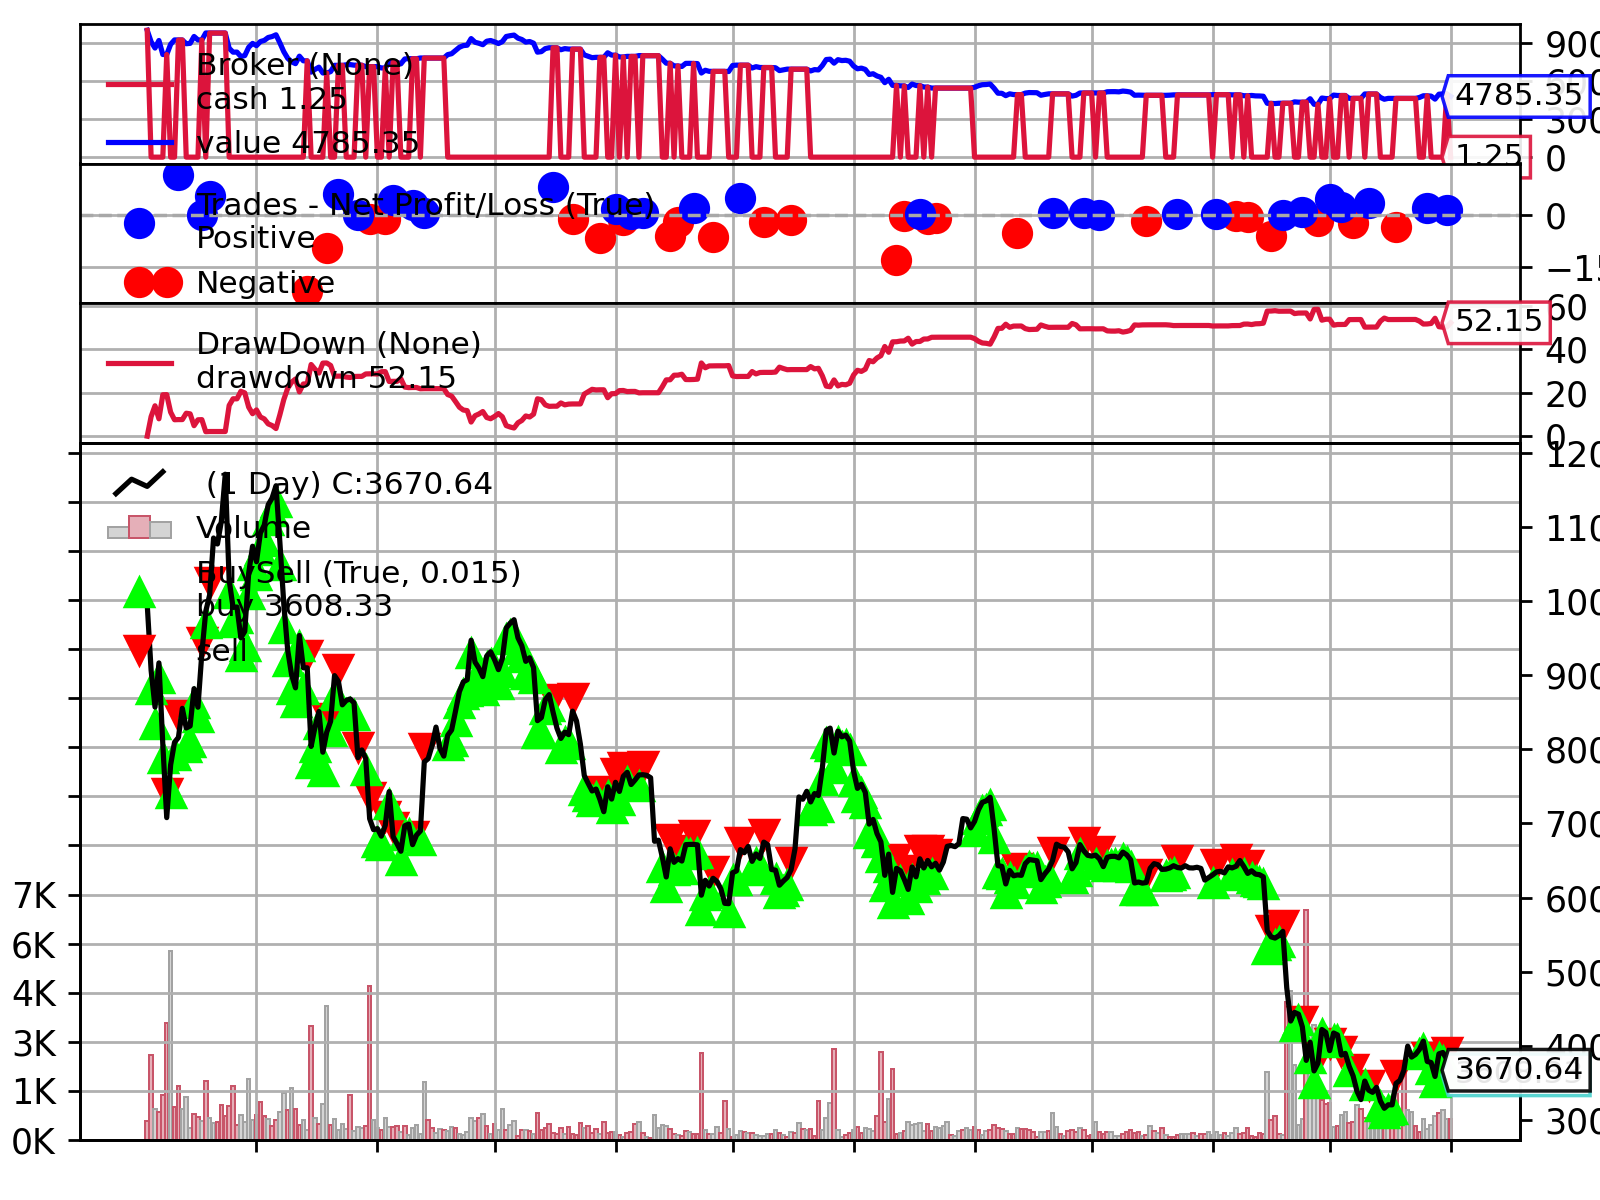

[[<Figure size 640x480 with 5 Axes>]]

In [49]:
cerebro.plot()